# Periodic Plasma Analysis

Program reads in field and particle data output from TFLink's frcr program run with parameter file test_periodicPlasma.parms.

In [15]:
# import Python libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from IPython.display import Markdown as md

# import TFNave libraries
import sys
sys.path.append("/Users/mlavell/TriForce/tfnavi")
import Maxwell_HDF5_reader as emH5
import ParticlePusher_HDF5_reader as ppH5
import TFNavi as navi

In [16]:
# constants
Mi= 1.67262192e-27
Me= 9.10938356e-31
qe= 1.60217663e-19
MH=1  # atomic number hydrogen
MC=6  # carbon
MO=16 # oxygen 
Kb= 1.38064852e-23
eps0= 8.8541878128e-12
tol = 1e-27

# function returns temperature and velocity drift
def getTempDrift(velx,mass):
    nparts = np.shape(velx)[0]
    sumV2 = 0; sumVDrift = np.zeros(3)
    for p in range(nparts):
        sumV2     += np.sum(velx[p]**2)
        sumVDrift += velx[p]
    temp   = mass/(3*Kb) * abs(sumV2/nparts-np.sum((sumVDrift/nparts)**2))
    vdrift = sumVDrift/nparts
    return temp,vdrift

# function returns Debye length for single species
def getDebyeLength(ndens,atomNum,temp):
    rmin = (4.0*np.pi*ndens/3.0)**(-1/3) # min mean interatomic distance
    debyelength = (ndens*(qe*atomNum)**2/(eps0*Kb*temp))**(-0.5)
    return max(rmin,debyelength)

# function returns Debye length for two species
def getDebyeLengthTwoSpecies(ndens1,atomNum1,temp1,ndens2,atomNum2,temp2):
    # min mean interatomic distance
    rmin = (4.0*np.pi*max(ndens1,ndens2)/3.0)**(-1/3)
    ldm2   = (ndens1*(qe*atomNum1)**2/(eps0*Kb*temp1) + ndens2*(qe*atomNum2)**2/(eps0*Kb*temp2))
    return max(rmin,ldm2**(-0.5))

# function returns plasma frequency
def getPlasmaFrequency(ndens,chrg,mass):
    return (ndens*(qe*chrg)**2/(eps0*mass))**0.5

# function returns array of velocity norms
def getVelocityNorm(vec3,nsteps):
    vnorm = np.zeros(nsteps)
    for s in range(nsteps):
        vnorm[s]= np.linalg.norm(vec3[s,:])
    return vnorm

# function returns thermal velocity
def getThermalVelocity(temperature,mass):
    return np.sqrt(Kb*temperature/mass)

### Load data and compute particle temperature and velocity drift

In [17]:
# load data/Maxwell.xdmf and data/ParticlePusher.xdmf
fdata = emH5.easy_read('data/periodicPlasma_')
pdata = ppH5.easy_read('data/periodicPlasma_')

# grid
nx= fdata.frames[0].dims[0]
ny= fdata.frames[0].dims[1]
nz= fdata.frames[0].dims[2]

xmin, xmax= ( 0, 0.01)
ymin, ymax= ( 0, 0.01)
zmin, zmax= ( 0, 0.01)

dx = (xmax-xmin)/nx
dy = (xmax-xmin)/ny
dz = (xmax-xmin)/nz

xx= np.linspace(xmin, xmax, nx)
yy= np.linspace(ymin, ymax, ny)
zz= np.linspace(zmin, zmax, nz)

vol= (xmax-xmin)*(ymax-ymin)*(zmax-zmin)

nParticles= pdata.frames[0].n_particles
charge    = pdata.frames[0].charges
mass      = pdata.frames[0].masses

ei=[] #electron indices
Hi=[] #hydrogen
Ci=[] #carbon
Oi=[] #oxygen

for ip in range(nParticles):
    if mass[ip] < tol: ei.append(ip) # electrons
    else: # ions
        if   (mass[ip]-MH*Mi<tol): Hi.append(ip)
        elif (mass[ip]-MC*Mi<tol): Ci.append(ip)
        else:                      Oi.append(ip)

nsteps= np.shape(pdata.frames)[0]
tps= np.zeros(nsteps)

eTemp = np.zeros(nsteps)
HTemp = np.zeros(nsteps)
CTemp = np.zeros(nsteps)
OTemp = np.zeros(nsteps)

eVelx = np.zeros((nsteps,3))
HVelx = np.zeros((nsteps,3))
CVelx = np.zeros((nsteps,3))
OVelx = np.zeros((nsteps,3))

for istep in range(nsteps):
    tps[istep]= 1e12*pdata.frames[istep].time
    
    eTemp[istep],eVelx[istep,:]= getTempDrift(pdata.frames[istep].velocities[ei],pdata.frames[istep].masses[ei[0]])
    HTemp[istep],HVelx[istep,:]= getTempDrift(pdata.frames[istep].velocities[Hi],pdata.frames[istep].masses[Hi[0]])
    CTemp[istep],CVelx[istep,:]= getTempDrift(pdata.frames[istep].velocities[Ci],pdata.frames[istep].masses[Ci[0]])
    OTemp[istep],OVelx[istep,:]= getTempDrift(pdata.frames[istep].velocities[Oi],pdata.frames[istep].masses[Oi[0]])
    
# read number density from output; we should read in parms file
ndens=1e14
lambdaDebye= getDebyeLength(ndens,1,eTemp[0]) 
DX=min(min(dx,dy),dz)

# velocity magnitude
ven = getVelocityNorm(eVelx,nsteps)
vHn = getVelocityNorm(HVelx,nsteps)
vCn = getVelocityNorm(CVelx,nsteps)
vOn = getVelocityNorm(OVelx,nsteps)

# thermal velocity
vthe= getThermalVelocity(eTemp[0],Me)
vthH= getThermalVelocity(eTemp[0],Mi*MH)
vthC= getThermalVelocity(eTemp[0],Mi*MC)
vthO= getThermalVelocity(eTemp[0],Mi*MO)

print("Finished loading and analysis.")

Finished loading and analysis.


In [19]:
print("Electron temperature = % 5.2e K = % 5.2f eV" %(eTemp[0],eTemp[0]/1.1606e4))
print("Hydrogen temperature = % 5.2e K = % 5.2f eV" %(HTemp[0],HTemp[0]/1.1606e4))
print("  Carbon temperature = % 5.2e K = % 5.2f eV" %(CTemp[0],CTemp[0]/1.1606e4))
print("  Oxygen temperature = % 5.2e K = % 5.2f eV" %(OTemp[0],OTemp[0]/1.1606e4))
print("")
print("DebyeLength_electron = % 5.2f um" %(lambdaDebye*1e6))
print("                  dx = % 5.2f um" %(DX*1e6))
print("")
print("number of electrons = "+str(len(ei)))
print("     number of ions = "+str(nParticles-len(ei)))
print("             H ions = "+str(len(Hi)))
print("             C ions = "+str(len(Ci)))
print("             O ions = "+str(len(Oi)))
#print("             mH ions = "+str(mass[Hi[0]]))
#print("             mC ions = "+str(mass[Ci[0]]))
#print("             mO ions = "+str(mass[Oi[0]]))
print("")
print(" Electron thermal velocity = %5.2e m/s" %(vthe))
print(" Hydrogen thermal velocity = %5.2e m/s" %(vthH))
print("   Carbon thermal velocity = %5.2e m/s" %(vthC))
print("   Oxygen thermal velocity = %5.2e m/s" %(vthO))

Electron temperature =  5.84e+04 K =  5.03 eV
Hydrogen temperature =  5.76e+04 K =  4.97 eV
  Carbon temperature =  5.85e+04 K =  5.04 eV
  Oxygen temperature =  5.93e+04 K =  5.11 eV

DebyeLength_electron =  1668.18 um
                  dx =  909.09 um

number of electrons = 4976
     number of ions = 5024
             H ions = 3087
             C ions = 1448
             O ions = 489

 Electron thermal velocity = 9.41e+05 m/s
 Hydrogen thermal velocity = 2.20e+04 m/s
   Carbon thermal velocity = 8.97e+03 m/s
   Oxygen thermal velocity = 5.49e+03 m/s


### Plot temperature and velocity evolution

Expect to see constant temperature of 5eV and no drift.

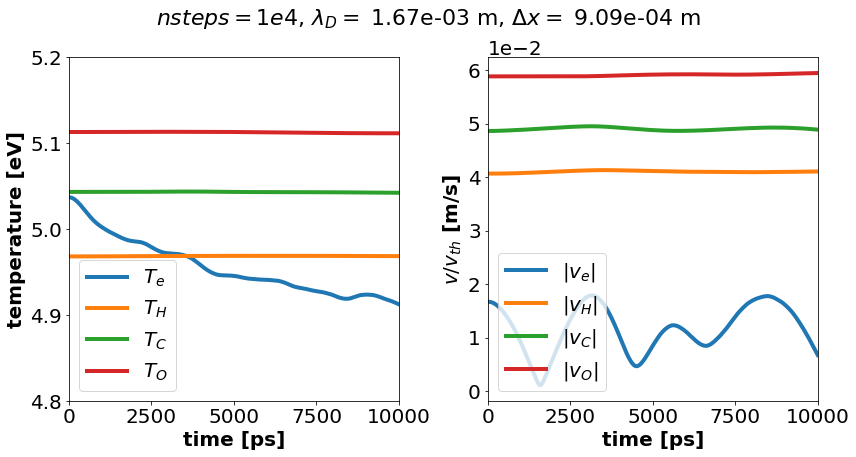

In [20]:
fig, ax = plt.subplots(1,2,figsize=(12,6),tight_layout=True)
fig.suptitle(r"$nsteps=1e4$, $\lambda_D =$ %5.2e m, $\Delta x =$ %5.2e m"%(lambdaDebye,DX),fontsize=22,y=1.05)

# plot temperature ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
ax[0].set_xlabel(r'time [ps]',fontsize=20,weight='bold')
ax[0].set_ylabel(r'temperature [eV]',fontsize=20,weight='bold')

# plot histograms for ions
ax[0].plot(tps,eTemp/11601,linewidth=4,label=r'$T_e$')
ax[0].plot(tps,HTemp/11601,linewidth=4,label=r'$T_H$')
ax[0].plot(tps,CTemp/11601,linewidth=4,label=r'$T_C$')
ax[0].plot(tps,OTemp/11601,linewidth=4,label=r'$T_O$')

ax[0].set_xlim([tps[0],tps[-1]])
ax[0].set_ylim([4.8,5.2])
ax[0].tick_params(labelsize=20)
ax[0].legend(fontsize=20)


# plot vx drift ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
ax[1].set_xlabel(r'time [ps]',fontsize=20,weight='bold')
ax[1].set_ylabel(r'$v/v_{th}$ [m/s]',fontsize=20,weight='bold')

# specific velocity direction
#ax[1].plot(tps,eVelx[:,0]/vthe,linewidth=4,label=r'$v_{x,e}$')
#ax[1].plot(tps,HVelx[:,0]/vthH,linewidth=4,label=r'$v_{x,H}$')
#ax[1].plot(tps,CVelx[:,0]/vthC,linewidth=4,label=r'$v_{x,C}$')
#ax[1].plot(tps,OVelx[:,0]/vthO,linewidth=4,label=r'$v_{x,O}$')

# velocity magnitude
ax[1].plot(tps,ven/vthe,linewidth=4,label=r'$|v_e|$')
ax[1].plot(tps,vHn/vthH,linewidth=4,label=r'$|v_H|$')
ax[1].plot(tps,vCn/vthC,linewidth=4,label=r'$|v_C|$')
ax[1].plot(tps,vOn/vthO,linewidth=4,label=r'$|v_O|$')

ax[1].set_xlim([tps[0],tps[-1]])
ax[1].tick_params(labelsize=20)
ax[1].ticklabel_format(style='sci', axis='y', scilimits=(0,0))
ax[1].yaxis.offsetText.set_fontsize(20)
ax[1].legend(fontsize=20)

plt.show()

### Plot particle velocity distribution functions

Expect to see Maxwellian distributions centered at zero.

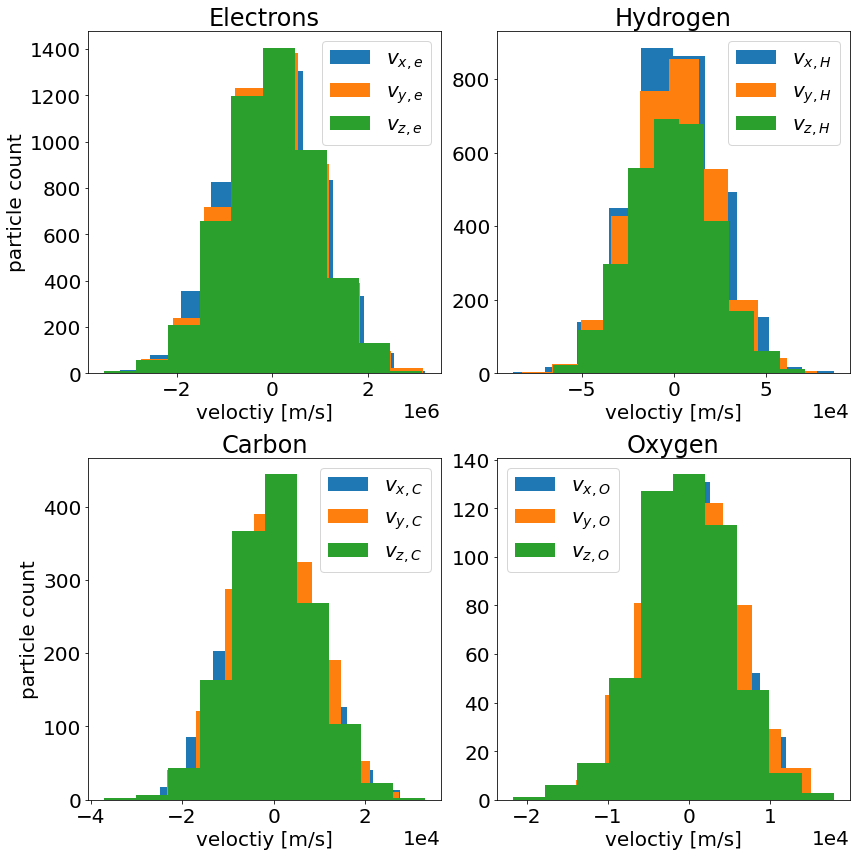

In [6]:
fn=0 # frame numbwe

fig, ax = plt.subplots(2,2,figsize=(12,12),tight_layout=True)

nbins = 8

ax[0][0].set_title("Electrons",fontsize=24)
ax[0][0].set_xlabel(r'veloctiy [m/s]',fontsize=20)
ax[0][0].set_ylabel(r'particle count',fontsize=20)
ax[0][0].hist(pdata.frames[fn].velocities[ei][:,0],label='$v_{x,e}$')
ax[0][0].hist(pdata.frames[fn].velocities[ei][:,1],label='$v_{y,e}$')
ax[0][0].hist(pdata.frames[fn].velocities[ei][:,2],label='$v_{z,e}$')

ax[0][1].set_title("Hydrogen",fontsize=24)
ax[0][1].set_xlabel(r'veloctiy [m/s]',fontsize=20)
ax[0][1].hist(pdata.frames[fn].velocities[Hi][:,0],label='$v_{x,H}$')
ax[0][1].hist(pdata.frames[fn].velocities[Hi][:,1],label='$v_{y,H}$')
ax[0][1].hist(pdata.frames[fn].velocities[Hi][:,2],label='$v_{z,H}$')

ax[1][0].set_title("Carbon",fontsize=24)
ax[1][0].set_xlabel(r'veloctiy [m/s]',fontsize=20)
ax[1][0].set_ylabel(r'particle count',fontsize=20)
ax[1][0].hist(pdata.frames[fn].velocities[Ci][:,0],label='$v_{x,C}$')
ax[1][0].hist(pdata.frames[fn].velocities[Ci][:,1],label='$v_{y,C}$')
ax[1][0].hist(pdata.frames[fn].velocities[Ci][:,2],label='$v_{z,C}$')

ax[1][1].set_title("Oxygen",fontsize=24)
ax[1][1].set_xlabel(r'veloctiy [m/s]',fontsize=20)
ax[1][1].hist(pdata.frames[fn].velocities[Oi][:,0],label='$v_{x,O}$')
ax[1][1].hist(pdata.frames[fn].velocities[Oi][:,1],label='$v_{y,O}$')
ax[1][1].hist(pdata.frames[fn].velocities[Oi][:,2],label='$v_{z,O}$')

# fitted gaussian  #yz,xz,_= ax.hist()
#(mux,sigmax)=norm.fit(vx) 
#norm.pdf( xx, mux, sigmax)

for axis in [ax[0][0],ax[0][1],ax[1][0],ax[1][1]]:
    #axis.set_xlim([-4e6,4e6])
    axis.tick_params(labelsize=20)
    axis.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
    axis.xaxis.offsetText.set_fontsize(20)  # fontsize of scientific notion exp
    axis.legend(fontsize=20)


plt.show()

### Field data

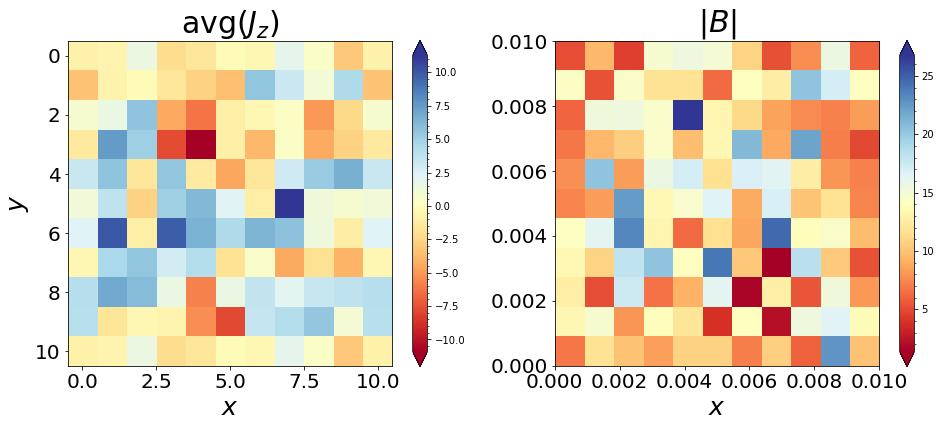

In [7]:
fn=1 # frame number

# field data ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# CHECK INDEXING!!


izhalf= int(fdata.frames[fn].dims[2]/2)
JzSlice= fdata.frames[fn].J.z_component[izhalf,:,:]
BxSlice= fdata.frames[fn].B.x_component[izhalf,:,:]

JzAvg     = np.zeros((nx,ny))
BmagzSlice= np.zeros((nx,ny))#np.shape(JzSlice))
for i in range(nx):
    for j in range(ny):
        JzAvg[i,j]= np.mean(fdata.frames[fn].J.z_component[:,i,j])
        BmagzSlice[i,j]= np.sqrt(fdata.frames[fn].B.x_component[izhalf,i,j]**2
                               + fdata.frames[fn].B.y_component[izhalf,i,j]**2
                               + fdata.frames[fn].B.z_component[izhalf,i,j]**2)
        
        
# plot ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
fig,ax = plt.subplots(1,2,figsize=(16,6))

# current
ax[0].set_title(r'avg($J_z$)',fontsize=30)
ax[0].set_xlabel(r'$x$',fontsize=25)
ax[0].set_ylabel(r'$y$',fontsize=25)
#ax[0].set_yscale('log')
#ax[0].set_xscale('log')
ax[0].tick_params(labelsize=20)


cmap=plt.cm.RdYlBu
jz= ax[0].imshow(JzAvg,cmap=cmap)
cbar = fig.colorbar(jz, ax=ax[0], extend='both')
cbar.minorticks_on()

# B field
ax[1].set_title(r'$|B|$',fontsize=30)
ax[1].set_xlabel(r'$x$',fontsize=25)
#ax[1].set_ylabel(r'y',fontsize=25)
ax[1].tick_params(labelsize=20)

bm= ax[1].imshow(BmagzSlice,extent=(xmin,xmax,ymin,ymax),cmap=cmap)
cbar = fig.colorbar(bm, ax=ax[1], extend='both')
cbar.minorticks_on()

plt.show()


## Field divergence

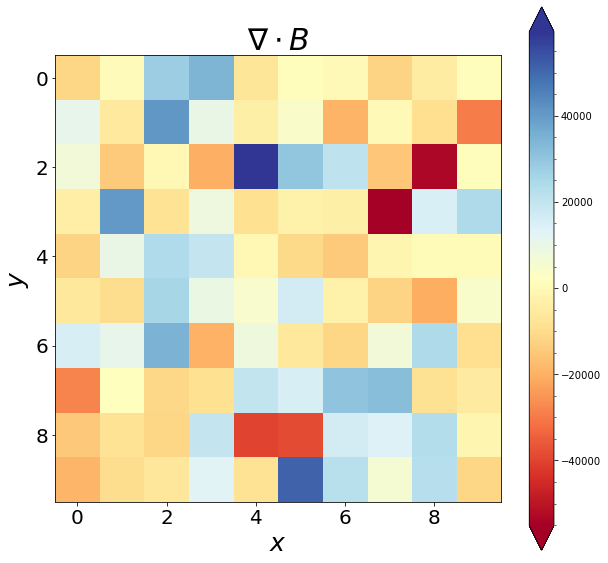

In [8]:
#def divB(B):
    
fn=1 # frame number

# grid
nx= fdata.frames[0].dims[0]
ny= fdata.frames[0].dims[1]
nz= fdata.frames[0].dims[2]

xmin, xmax= ( 0, 0.01)
ymin, ymax= ( 0, 0.01)
zmin, zmax= ( 0, 0.01)

dx = (xmax-xmin)/nx
dy = (xmax-xmin)/ny
dz = (xmax-xmin)/nz

xx= np.linspace(xmin, xmax, nx)
yy= np.linspace(ymin, ymax, ny)
zz= np.linspace(zmin, zmax, nz)

divB= np.zeros((nx-1,ny-1,nz-1))

Bx= fdata.frames[fn].B.x_component
By= fdata.frames[fn].B.y_component
Bz= fdata.frames[fn].B.z_component

for i in range(nx-1):
    for j in range(ny-1):
        for k in range(nz-1):
            divB[i,j,k]= (Bx[i+1,j,k]-Bx[i,j,k])/dx + (By[i,j+1,k]-By[i,j,k])/dy + (Bz[i,j,k+1]-Bz[i,j,k])/dz
                                                             
# plot ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
fig,ax = plt.subplots(1,1,figsize=(10,10))

ax.set_title(r'$\nabla \cdot B$',fontsize=30)
ax.set_xlabel(r'$x$',fontsize=25)
ax.set_ylabel(r'$y$',fontsize=25)
ax.tick_params(labelsize=20)


cmap=plt.cm.RdYlBu
db= ax.imshow(divB[:,int(nz/2),:],cmap=cmap)
cbar = fig.colorbar(db, ax=ax, extend='both')
cbar.minorticks_on()
                                                                                       
plt.show()